# Exercise 10: GANs

In [1]:
# Load packages we need
import sys
import os
import datetime

import numpy as np
import sklearn

import scipy as sp
import pandas as pd

import tensorflow as tf

# we'll use tensorflow and keras for neural networks
import tensorflow as tf
import tensorflow.keras as keras

# import layers we may use
from tensorflow.keras.layers import Input, Flatten, Reshape, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout

# import callbacks we may use
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 20})

# Let's check our software versions
print('### Python version: ' + sys.version)
print('### Numpy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('------------')


# load our packages / code
sys.path.insert(1, '../common/')
import utils
import plots
import nets

### Python version: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
### Numpy version: 1.18.5
### Scikit-learn version: 0.24.0
### Tensorflow version: 2.3.1
------------


In [2]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 42

# deterministic seed for reproducibility
np.random.seed(seed)
tf.random.set_seed(seed)

prop_vec = [24, 2, 2]

### Code to train the GAN

In [3]:
def gan_train_loop(gan, generator, discriminator, train_x, batch_size=200, latent_width=64, alpha=0.25, verbose=False):
       
    discr_loss_avg = 0.0
    gan_loss_avg = 0.0
        
    n = train_x.shape[0]
    num_full_batches = n / batch_size
    batch_idx = 0
    for i in range(0, n, batch_size):
        batch_start_idx = i
        batch_end_idx = np.minimum(n, batch_start_idx+batch_size)
        
        real_data_batch = train_x[batch_start_idx:batch_end_idx]
        
        # 1. train the discriminator for one step       
        # create batch of real & fake data
        eff_batch_size = real_data_batch.shape[0]
        noise_samples = tf.random.normal((eff_batch_size, latent_width), mean=0.0, stddev=1.0)
        fake_data_batch = generator.predict(noise_samples)
        
        # create the labels for these batches (1 -> real, 0 -> fake)
        discr_batch_real = tf.ones((eff_batch_size,), dtype=tf.float32)
        discr_batch_fake = tf.zeros((eff_batch_size,), dtype=tf.float32)
        discr_batch_y = tf.concat([discr_batch_real, discr_batch_fake], axis=0)
        
        # concatenate the two sets
        discr_batch_x = tf.concat([real_data_batch, fake_data_batch], axis=0)
        
        # train the discriminator for one step
        discriminator.trainable = True # make trainable
        discr_loss = discriminator.train_on_batch(discr_batch_x, discr_batch_y)
        
        # moving average for discr_loss
        discr_loss_avg = discr_loss if i==0 else alpha * discr_loss + (1.0 - alpha) * discr_loss_avg
        
        
        # 2. train the generator for one step       
        noise_samples = tf.random.normal([batch_size, latent_width], mean=0.0, stddev=1.0)
                
        # create the labels (pretend these are real images -> label = 1)
        pretend_labels = tf.ones((batch_size,), dtype=tf.float32)
        
        # do one training step
        discriminator.trainable = False # freeze the discriminator
        gan_loss = gan.train_on_batch(noise_samples, pretend_labels)
        
        # moving average for gan_loss
        gan_loss_avg = gan_loss if i==0 else alpha * gan_loss + (1.0 - alpha) * gan_loss_avg
        
        # verbose
        if verbose:
            if np.mod(batch_idx, num_full_batches // 10) == 0:                                      
                sys.stdout.write('.')
                sys.stdout.flush()
            
            if batch_end_idx == n:
                noise_samples = tf.random.normal([batch_size, latent_width], mean=0.0, stddev=1.0)
                gen_samples = generator.predict(noise_samples)
                plots.plot_images(gen_samples[0:10].reshape(-1, 28, 28), dim_x=28, dim_y=28, one_row=True, fig_size=(14,3))
        
        batch_idx += 1
        
    if verbose:   
        sys.stdout.write('\n')
        sys.stdout.flush()
        
    return discr_loss_avg, gan_loss_avg

### Load MNIST data.

In [4]:
# grab the data
train_x, train_y, test_x, test_y, val_x, val_y, all_x, all_y = utils.load_preprocess_mnist_data(onehot=False, flatten=False, prop_vec=prop_vec, seed=seed)

# sanity check shapes
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((60000, 28, 28), (60000,), (5000, 28, 28), (5000,), (5000, 28, 28), (5000,))

In [5]:
# renormalize the data so all pixel values are in the [0,1] range 
train_x = train_x / 255.0
test_x = test_x / 255.0
val_x = val_x / 255.0

# reshape   
train_x = train_x.reshape(-1, 28, 28, 1)

In [6]:
latent_width = 100

gan, generator, discriminator = nets.create_gan(latent_width=latent_width, verbose=False)

generator.summary()
discriminator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen-fc1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
gen-deconv1 (Conv2DTranspose (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
gen-deconv2 (Conv2DTranspose (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 128)       0 

### Train the GAN

In [10]:
generator_fp = './gen.h5'

train = False
#train = True

if train:
    num_epochs = 50
    batch_size = 256

    for i in range(num_epochs):
        discr_loss_avg, gan_loss_avg = gan_train_loop(gan, generator, discriminator, train_x, 
                                                      batch_size=batch_size, latent_width=latent_width, verbose=True)

        print('Epoch {} - discriminator loss: {:.4f}, gan loss: {:.4f}'.format(i, discr_loss_avg, gan_loss_avg))
        
    generator.save(generator_fp)
else:
    gen = keras.models.load_model(generator_fp)

### Generate new instances

In [11]:
noise_samples = tf.random.normal((100, latent_width), mean=0.0, stddev=1.0)
gen_samples = generator.predict(noise_samples)

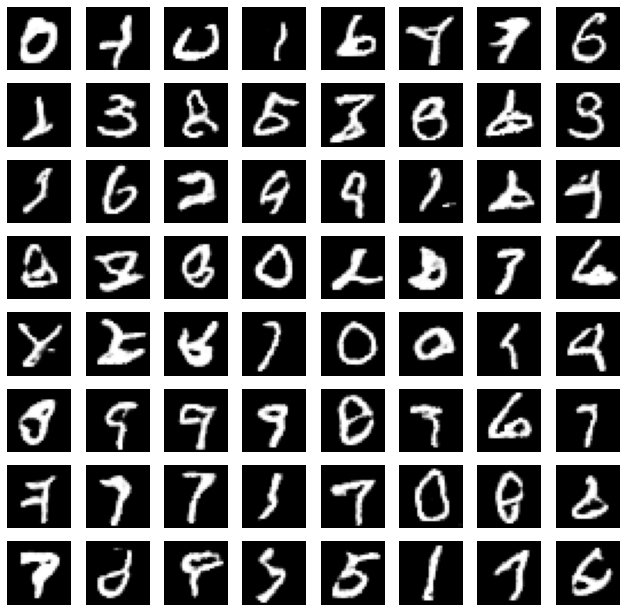

In [12]:
plots.plot_images(gen_samples[0:64].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(11,11))